In [1]:
REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Cloning into '2022-2023-DGM-MIPT-course'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 527 (delta 14), reused 27 (delta 7), pack-reused 482
Receiving objects: 100% (527/527), 183.50 MiB | 21.01 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (303/303), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./2022-2023-DGM-MIPT-course/homeworks
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dgm-utils: filename=dgm_utils-0.1.0-py3-n

In [3]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import visualize_2d_data, visualize_2d_samples
from dgm_utils import show_samples, visualize_images, load_pickle

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import models

USE_CUDA = torch.cuda.is_available()

In [5]:
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence

def get_normal_KL(mean_1, log_std_1, mean_2=None, log_std_2=None):
    """
        This function should return the value of KL(p1 || p2),
        where p1 = Normal(mean_1, exp(log_std_1)), p2 = Normal(mean_2, exp(log_std_2) ** 2).
        If mean_2 and log_std_2 are None values, we will use standard normal distribution.
        Note that we consider the case of diagonal covariance matrix.
    """
    if mean_2 is None:
        mean_2 = torch.zeros_like(mean_1)
    if log_std_2 is None:
        log_std_2 = torch.zeros_like(log_std_1)
    p_1 = Normal(mean_1, torch.exp(log_std_1))
    p_2 = Normal(mean_2, torch.exp(log_std_2))

    return kl_divergence(p_1 , p_2)

def test_KL():
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(0), torch.tensor(0)).numpy(), 200.2144, rtol=1e-3)
    assert np.isclose(get_normal_KL(torch.tensor(2), torch.tensor(3), torch.tensor(4), torch.tensor(5)).numpy(), 1.50925, rtol=1e-3)
    assert np.allclose(get_normal_KL(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), [49.2990, 1498.479], rtol=1e-3)


test_KL()

In [6]:
def get_normal_nll(x, mean, log_std):
    """
        This function should return the negative log likelihood log p(x),
        where p(x) = Normal(x | mean, exp(log_std) ** 2).
        Note that we consider the case of diagonal covariance matrix.
    """
    p = Normal(mean, torch.exp(log_std))
    return -p.log_prob(x)


def test_NLL():
    assert np.isclose(get_normal_nll(torch.tensor(2), torch.tensor(2), torch.tensor(3)).numpy(), 3.9189, rtol=1e-3)
    assert np.isclose(get_normal_nll(torch.tensor(5), torch.tensor(-3), torch.tensor(6)).numpy(), 6.9191, rtol=1e-3)
    assert np.allclose(get_normal_nll(torch.tensor((10, 10)), torch.tensor((2, 4)), torch.tensor((3, 5))).numpy(), np.array([3.9982, 5.9197]), rtol=1e-3)


test_NLL()

## Task: ResNet VAE on CIFAR10 data

In this task you will implement VAE model with ResNet architecture for CIFAR10 dataset.

Download the data from [here](https://drive.google.com/file/d/1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj/view?usp=sharing) (you could use the cell below).

In [6]:
!gdown --id 1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FZcV8Mm91fiXm2jFnB0jvK5ROyHdJFvj
To: /content/cifar10.pkl
100% 185M/185M [00:00<00:00, 253MB/s]


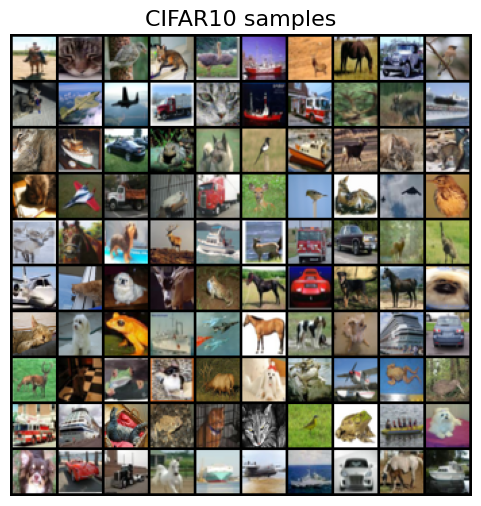

In [7]:
train_data, test_data = load_pickle('content/cifar10.pkl', flatten=False, binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

### ResNet encoder for CIFAR 10

The architecrure of encoder:
1. Conv2D(3, 8)
2. ResNet(8, 64) with 3 residual blocks

Code of ResNet from [here](https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/)

In [ ]:
def conv3x3(in_channels, out_channels, stride=1, kernel_size=3):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                     stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        
        self.conv1 = conv3x3(3, 8, kernel_size=5)
        
        self.in_channels = 8        
        self.layer1 = self.make_layer(block, 16, layers[0], 2)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2])

        self.conv2 = conv3x3(64, 128, kernel_size=5)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
#         out = self.conv2(out)
        
        return out

ResNet(ResidualBlock, [1, 1, 1])

### ResNet decoder for CIFAR 10
The architecrure of decoder:
1. ResNetTranspose(64, 8) with 3 transposed residual blocks
2. ConvTranspose2D(8, 3)

In [ ]:
def conv_transpose3x3(in_channels, out_channels, stride=1, kernel_size=3):
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size,
                     stride=stride, padding=1, bias=False)

class ResidualBlockTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlockTranspose, self).__init__()
        self.conv1 = conv_transpose3x3(in_channels, in_channels, stride)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv_transpose3x3(in_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


# ResNet
class ResNetTranspose(nn.Module):
    def __init__(self, block, layers):
        super(ResNetTranspose, self).__init__()
        self.conv1 = conv_transpose3x3(128, 64, kernel_size=5)
        
        self.in_channels = 64
        self.layer1 = self.make_layer(block, 32, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[1], 2)
        self.layer3 = self.make_layer(block, 8, layers[2], 2)
        
        self.conv2 = conv_transpose3x3(8, 3, kernel_size=5)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        for i in range(1, blocks):
            layers.append(block(self.in_channels, self.in_channels))
        
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv_transpose3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
#         out = self.conv1(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.conv2(out)
        return out

ResNetTranspose(ResidualBlockTranspose, [1, 1, 1])

### Encoder/decoder realisation

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, input_shape, n_latent):
        super(ConvEncoder, self).__init__()
        self.input_shape = input_shape
        self.n_latent = n_latent
        self.resnet = ResNet(ResidualBlock, [1, 1, 1])
        self.fc_layer = nn.Linear(64 * 8 * 8, 2 * self.n_latent)

    def forward(self, x):
        x = self.resnet(x)  # ResNet
#         print(x.shape)
        x = x.reshape(x.size(0), -1)  # flatten output of conv
        mu, log_std = self.fc_layer(x).chunk(2, dim=1)
        return mu, log_std




class ConvDecoder(nn.Module):
    def __init__(self, n_latent, output_shape):
        super(ConvDecoder, self).__init__()
        self.n_latent = n_latent
        self.output_shape = output_shape

        self.fc_layer = nn.Linear(self.n_latent, 64 * 8 * 8)
        self.resnet = ResNetTranspose(ResidualBlockTranspose, [1, 1, 1])
        self.batch_norm = nn.BatchNorm1d(64 * 8 * 8)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, z):
        z = self.fc_layer(z).view(-1, 64, 8, 8)
        z = self.resnet(z)
        z = F.interpolate(z, size=(32, 32), mode='bilinear')
        return z


############### TEST ###############
test_conv_encoder = ConvEncoder(train_data[0].shape, n_latent=256)
mu_test, log_std_test = test_conv_encoder(torch.tensor(train_data[:2]))
z = torch.exp(log_std_test) * Normal(.0, 1.).sample([256]) + mu_test
print(z.shape)
test_conv_decoder = ConvDecoder(256, train_data[0].shape)
test_conv_decoder(z).shape

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta
        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):
        z = Normal(.0, 1.).sample([n])
        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        mu_z, log_std_z = self.encoder(x)
        z = torch.exp(log_std_z) * self.prior(self.n_latent) + mu_z
        x_recon = self.decoder(z)
        return mu_z, log_std_z, x_recon

    def loss(self, x):
        mu_z, log_std_z, x_recon = self(x)
        # print(mu_z.shape, log_std_z.shape, x_recon.shape)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros((x.shape[0],) + self.input_shape).cuda()).mean()
        kl_loss = get_normal_KL(mu_z, log_std_z).mean()
        return {
            'elbo_loss': recon_loss + self.beta * kl_loss,
        }
        #     'recon_loss': recon_loss,
        #     'kl_loss': kl_loss
        # }

    def sample(self, n):
        with torch.no_grad():
            priors = torch.stack([self.prior(self.n_latent) for _ in range(n)])
            x_recon = self.decoder(priors)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

In [ ]:
BATCH_SIZE = 2048 # any adequate value
EPOCHS = 50       # < 16
LR = 1e-4         # < 1e-3
N_LATENS = 256    # 128 < _ < 1024
BETA = 1e-3          # 0.1 < _ < 10

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA).cuda()

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key='elbo_loss',
    use_tqdm=True,
    use_cuda=USE_CUDA,
)
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

In [84]:
class ConvVAE(nn.Module):
    def __init__(self, input_shape, n_latent, beta=1):
        super().__init__()
        assert len(input_shape) == 3

        self.input_shape = input_shape
        self.n_latent = n_latent
        self.beta = beta
        self.encoder = ConvEncoder(self.input_shape, self.n_latent)
        self.decoder = ConvDecoder(self.n_latent, self.input_shape)

    def prior(self, n, use_cuda=True):
        z = Normal(.0, 1.).sample([n])
        if use_cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        mu_z, log_std_z = self.encoder(x)
        z = torch.exp(log_std_z) * self.prior(self.n_latent) + mu_z
        x_recon = self.decoder(z)
        return mu_z, log_std_z, x_recon

    def loss(self, x):
        mu_z, log_std_z, x_recon = self(x)
        # print(mu_z.shape, log_std_z.shape, x_recon.shape)
        recon_loss = get_normal_nll(x, x_recon, torch.zeros((x.shape[0],) + self.input_shape).cuda()).mean()
        kl_loss = get_normal_KL(mu_z, log_std_z).mean()
        return {
            'elbo_loss': recon_loss + self.beta * kl_loss,
        }
        #     'recon_loss': recon_loss,
        #     'kl_loss': kl_loss
        # }

    def sample(self, n):
        with torch.no_grad():
            priors = torch.stack([self.prior(self.n_latent) for _ in range(n)])
            x_recon = self.decoder(priors)
            samples = torch.clamp(x_recon, -1, 1)
        return samples.cpu().numpy() * 0.5 + 0.5

  0%|          | 0/50 [00:00<?, ?it/s]

elbo_loss: 0.9449


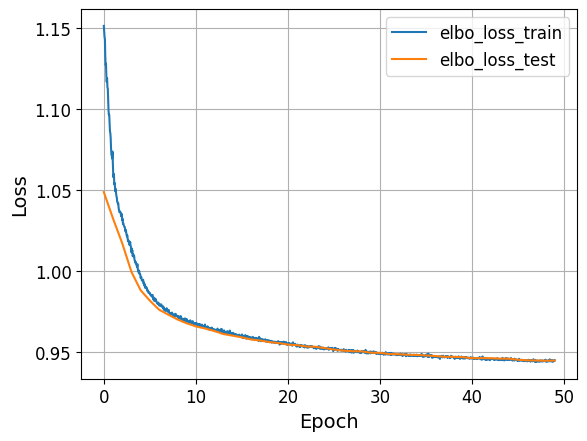

In [95]:
BATCH_SIZE = 2048 # any adequate value
EPOCHS = 50       # < 16
LR = 1e-4         # < 1e-3
N_LATENS = 256    # 128 < _ < 1024
BETA = 1e-3          # 0.1 < _ < 10

# we center the data, because it helps the model to fit
centered_train_data = train_data * 2 - 1
centered_test_data = test_data * 2 - 1

train_loader = data.DataLoader(centered_train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(centered_test_data, batch_size=BATCH_SIZE)

model = ConvVAE((3, 32, 32), N_LATENS, BETA).cuda()

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key='elbo_loss',
    use_tqdm=True,
    use_cuda=USE_CUDA,
)
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))
plot_training_curves(train_losses, test_losses)

In [96]:
for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-4]))
    print('{}: {:.4f}'.format(key, value[-3]))
    print('{}: {:.4f}'.format(key, value[-2]))
    print('{}: {:.4f}'.format(key, value[-1]))

elbo_loss: 0.9451
elbo_loss: 0.9450
elbo_loss: 0.9449
elbo_loss: 0.9449


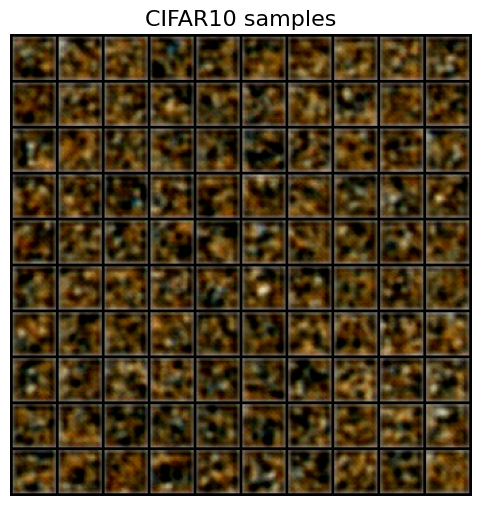

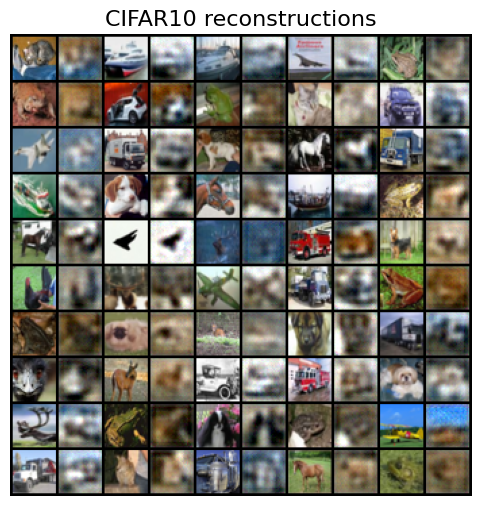

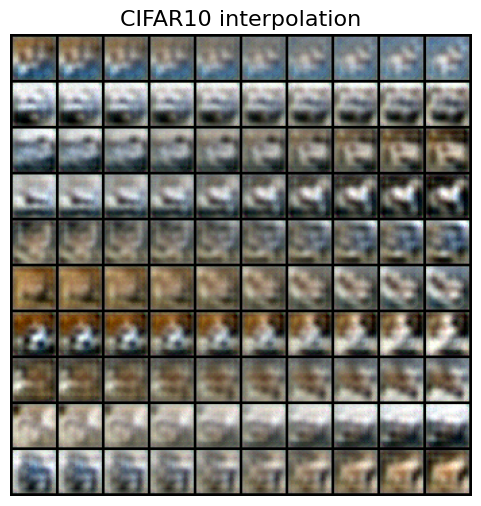

In [98]:
samples = model.sample(100)
show_samples(samples, 'CIFAR10 samples')

x = next(iter(test_loader))[:50]

if USE_CUDA:
    x = x.cuda()

with torch.no_grad():
    z, _ = model.encoder(x)
    x_recon = torch.clamp(model.decoder(z), -1, 1)
reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
reconstructions = reconstructions.cpu().numpy()
show_samples(reconstructions, 'CIFAR10 reconstructions')

x = next(iter(test_loader))[:20].cuda()
with torch.no_grad():
    z, _ = model.encoder(x)
    z1, z2 = z.chunk(2, dim=0)
    interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
    interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
interps = interps.cpu().numpy()
show_samples(interps, 'CIFAR10 interpolation')